In [22]:
# Import the necessary libs for the homework
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import pandas as pd


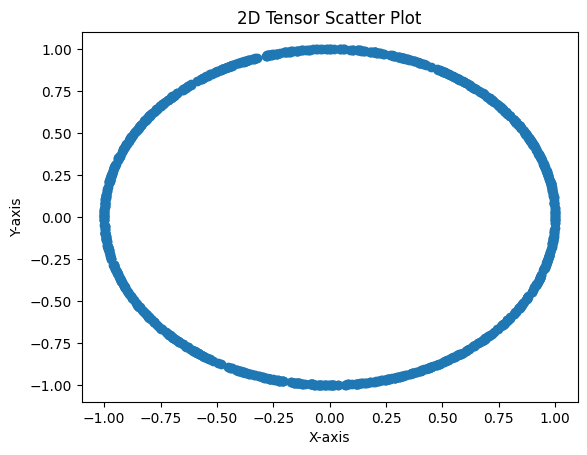

In [23]:
# Generate the initial dataset :
train_len = 1024
train_data = torch.zeros(train_len, 2)

# Generate random angles
theta = 2 * math.pi * torch.rand(train_len)

# Convert polar coordinates to Cartesian coordinates
radius = 1
x = radius * torch.cos(theta)
y = radius * torch.sin(theta)

train_data[:,0] = x
train_data[:,1] = y

# Plots the content of the tensor to make sure it's what i want
plt.scatter(train_data[:,0], train_data[:,1])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Tensor Scatter Plot')
plt.show()


# Format the initial data into a loader to make a more efficient code :
batch_size = 32                         # --------------------------------------------------------  Batch size 

# Wrap the tensor in a TensorDataset to assure compatibility in the code :
train_dataset = torch.utils.data.TensorDataset(train_data)

# Create a DataLoader using the dataset :
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
# Let's start with the generator as a simple neural network 
class Generator(nn.Module):

     def __init__(self):
         super().__init__()
         self.model = nn.Sequential(
             nn.Linear(3, 16), # Input is 3 dimensional
             nn.ReLU(),
             nn.Linear(16, 32),
             nn.ReLU(),
             nn.Linear(32, 64),
             nn.ReLU(),
             nn.Linear(64, 32),
             nn.ReLU(),
             nn.Linear(32, 2),  # Output is two dimensional
         )

     def forward(self, x):
         output = self.model(x)
         return output

# Build the discriminator as a NN
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), #the input is two-dimensional
            nn.ReLU(),
            nn.Dropout(0.3), #droput layers reduce overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), #sigmoid activation to represent probability
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [25]:
# Sets the parameters
lr = 0.001
loss_function = nn.BCELoss()
num_epochs = 500

Epoch: 0 Loss D.: 0.12080539762973785
Epoch: 0 Loss G.: 4.947499752044678


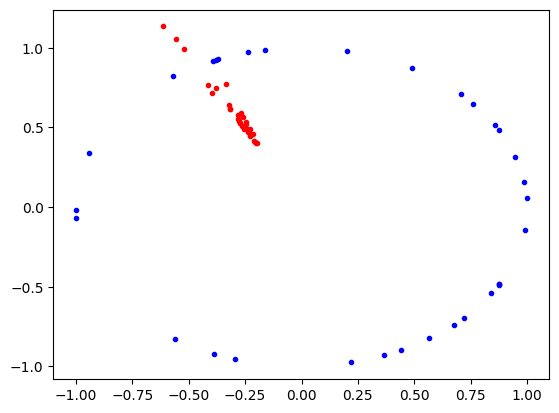

Epoch: 100 Loss D.: 0.6693210601806641
Epoch: 100 Loss G.: 0.7767735719680786


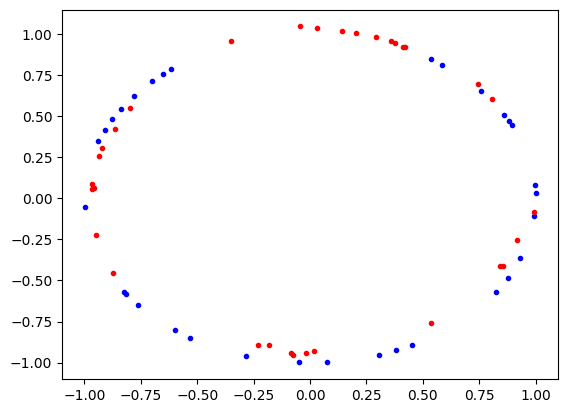

Epoch: 200 Loss D.: 0.6886366605758667
Epoch: 200 Loss G.: 0.7971051931381226


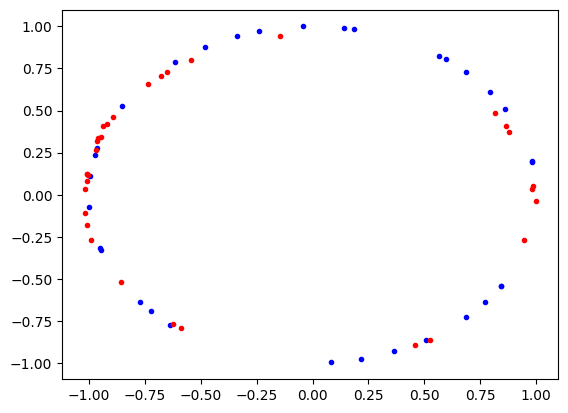

Epoch: 300 Loss D.: 0.7282381057739258
Epoch: 300 Loss G.: 0.7333956956863403


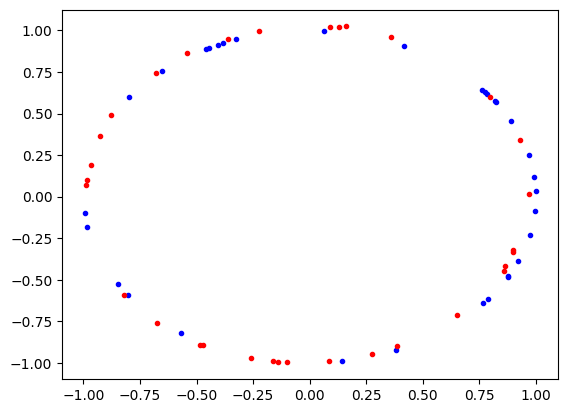

Epoch: 400 Loss D.: 0.7104312181472778
Epoch: 400 Loss G.: 0.6887176036834717


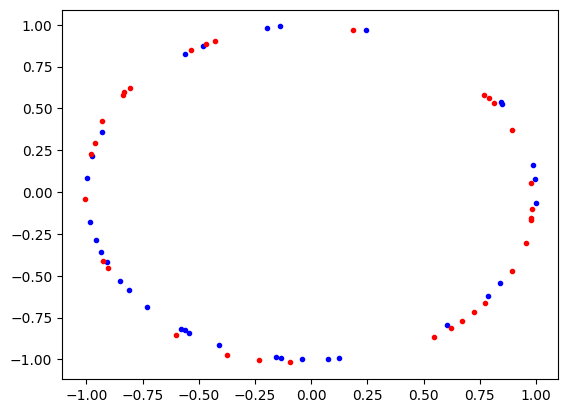

In [26]:
# Training loop :

discriminator = Discriminator()
generator = Generator()
gen_loss_vector = []
discr_loss_vector = []
num_epoch_vector = []


optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=2*lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for idx, real_data_set in enumerate(train_loader):
        real_data_set = real_data_set[0]
        # Preparing the real data to train the discriminator:
        real_data_label = torch.ones(batch_size,1)

        # Preparing the fake data to train the discriminator: 
        noise_data_set = torch.randn((batch_size, 3))
        fake_data_set = generator(noise_data_set)
        fake_data_label = torch.zeros(batch_size, 1)

        # Creating the training samples set:
        training_data_set = torch.cat((real_data_set, fake_data_set))

        # Creating the training labels set:
        training_labels_set = torch.cat((real_data_label, fake_data_label))

        # Train the discriminator:
        discriminator.zero_grad()
        output_discriminator = discriminator(training_data_set)
        loss_discriminator = loss_function(
            output_discriminator, training_labels_set)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Initialising the data for the generator: 
        noise_data_set = torch.randn((batch_size, 3))

        # Train the generatot: 
        generator.zero_grad()
        output_generator = generator(noise_data_set)
        
        # We use the discriminator output to back propagate:
        output_discriminator_generated  = discriminator(output_generator)
        loss_generator = loss_function(
            output_discriminator_generated, real_data_label) 
        # We put label = 1 so that the error we want to minimize is the distance between our generated data and the label 1

        loss_generator.backward()
        optimizer_generator.step()

        # prepares data for loss plot afterwise:
        if idx == batch_size-1:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)

        # Show loss
        if epoch % 100 == 0 and idx == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


            generated_samples_for_plotting = output_generator.detach()

            # Plot real samples in blue
            plt.plot(real_data_set[:, 0], real_data_set[:, 1], ".", color='blue')
            
            # Plot generated samples in red
            plt.plot(generated_samples_for_plotting[:, 0], generated_samples_for_plotting[:, 1], ".", color='red')
            
            plt.show()



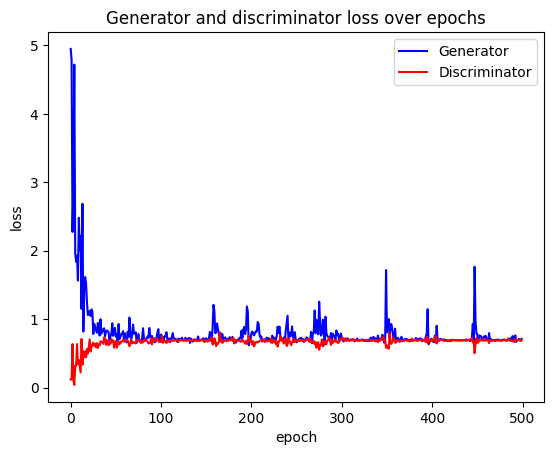

In [27]:
# Plot the functions on the same graph
plt.plot(num_epoch_vector, gen_loss_vector, label='Generator', color = 'b')  # Plot sine function with label
plt.plot(num_epoch_vector, discr_loss_vector, label='Discriminator', color = 'r')  # Plot cosine function with label
plt.legend()  # Show legend with function labels
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator and discriminator loss over epochs')
plt.show()